In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats import kurtosis, skew
import gc
import json
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from pathlib import Path
import sys
import re

from scripts import feature_engineering

In [3]:
path=Path('/kaggle/data_science_bowl')
path

PosixPath('/kaggle/data_science_bowl')

In [4]:
def read_data():
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    train_labels_df = pd.read_csv(path/'train_labels.csv')
    specs_df = pd.read_csv(path/'specs.csv')
    return train_df, test_df, train_labels_df, specs_df

In [5]:
%%time
train_df, test_df, train_labels_df, specs_df = read_data()

CPU times: user 41.5 s, sys: 3.12 s, total: 44.6 s
Wall time: 51.9 s


In [6]:
train_df.shape

(11341042, 11)

## Feature Engineering

### Cleanup

In [7]:
train_df = feature_engineering.remove_wrong_event_codes(train_df)
test_df = feature_engineering.remove_wrong_event_codes(test_df)

In [8]:
train_df = feature_engineering.remove_ids_with_no_assessment(train_df)

In [9]:
list_of_user_activities, activities_labels, activities_map, win_code, assess_titles, list_of_event_code, \
list_of_event_id, list_of_worlds, list_of_title, list_of_event_code_world, list_of_event_code_title, list_of_event_id_world = \
feature_engineering.create_structs(train_df, test_df)

In [10]:
train_samples = [(installation_id, user_sample) for (installation_id, user_sample) in train_df.groupby('installation_id')]
test_samples = [(installation_id, user_sample) for (installation_id, user_sample) in test_df.groupby('installation_id')]

In [11]:
comp_train_df = feature_engineering.feature_generation(train_samples, False,
                                                       assess_titles=assess_titles, list_of_event_code=list_of_event_code,
                                                       list_of_event_id=list_of_event_id, list_of_worlds=list_of_worlds,
                                                       list_of_title=list_of_title, win_code=win_code, 
                                                       activities_map=activities_map, 
                                                       list_of_event_code_world=list_of_event_code_world,
                                                       list_of_event_code_title=list_of_event_code_title,
                                                       list_of_event_id_world=list_of_event_id_world)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/fastai/fastai-exercises/nbs_gil/data_science_bowl/scripts/feature_engineering.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session["passed"] = session.loc[:, "timestamp"].diff().apply(lambda x: x.seconds)


In [12]:
comp_train_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,title_duration_meanChest Sorter (Assessment),title_duration_meanCart Balancer (Assessment),title_duration_meanMushroom Sorter (Assessment),title_duration_meanCauldron Filler (Assessment),title_duration_meanBird Measurer (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,6c517a88,30614231,9b23e8ee,d2e9262e,3babcb9b,c0415e5c,736f9581,f50fc6c1,2dc29e21,25fa8af4,a1bbe385,37937459,69fdac0a,b1d5101d,eb2c19cd,c277e121,7d5c30a2,83c6c409,28a4eb9a,abc5811c,4a4c3d21,31973d56,b2e5b0f1,67439901,250513af,08fd73f3,e4d32835,47efca07,5290eab1,0a08139c,76babcde,5f0eb72c,a16a373e,b120f2ac,2ec694de,86ba578b,a2df0760,1cc7cfca,08ff79ad,598f4598,90d848e0,7ec0c298,c7128948,e3ff61fb,e64e2cfd,ec138c1c,4901243f,923afab1,5c3d2b2f,5de79a6a,4d6737eb,d122731b,58a0de5c,8ac7cce4,bc8f2793,9c5ef70c,16dffff1,bfc77bd6,ecaab346,de26c3a6,857f21c0,587b5989,7d093bf9,36fa3ebe,ad2fc29c,5b49460a,3bfd1a65,1c178d24,56817e2b,022b4259,c7f7f0e1,a592d54e,a6d66e51,05ad839b,90efca10,bd612267,6f8106d9,a1192f43,8d84fa81,e720d930,4bb2f698,5e812b27,99ea62f3,46b50ba8,77ead60d,f93fc684,c58186bf,f28c589a,0d18d96c,bdf49a58,9554a50b,d45ed6a1,1f19558b,29f54413,29bdd9ba,3ccd3f02,cf82af56,a44b10dc,d06f75b5,c952eb01,a8a78786,884228c8,7ab78247,ab4ec3a4,2fb91ec1,6f445b57,8b757ab8,2b058fe3,f806dc10,15eb4a7d,5a848010,cf7638f3,9b01374f,37ee8496,1bb5fbdb,3d0b9317,92687c59,55115cbd,1cf54632,7961e599,ecc36b7f,9de5e594,2b9272f4,262136f4,763fc34e,363c86c9,a8efe47b,99abe2bb,7ad3efc6,6088b756,63f13dd7,f3cd5473,17113b36,5e3ea25a,48349b14,88d4a5be,6077cc36,53c6e11a,0db6d71d,6f4bd64e,45d01abe,2a512369,e080a381,8fee50e2,1996c610,6cf7d25c,f5b8c21a,3edf6747,fbaf3456,2a444e03,9e6b7fb5,895865f3,792530f8,67aa2ada,9d29771f,5c2f29ca,119b5b02,795e4a37,e5c9df6f,0413e89d,ab3136ba,3bb91ced,b74258a0,ca11f653,d3f1e122,a76029ee,db02c830,0330ab6a,6043a2b4,ad148f58,85d1b0de,d3268efa,7dfe6d8a,acf5c23f,e7e44842,d88ca108,363d3849,cb6010f8,461eace6,28ed704e,47f43a44,fd20ea40,7fd1ac25,3ddc79c3,47026d5f,49ed92e9,709b1251,46cd75b4,d38c2fd7,222660ff,f54238ee,dcaede90,2c4e6db0,29a42aea,cfbd47c8,a7640a16,bbfe0445,c74f40cd,d2659ab4,0086365d,5859dfb6,828e68f9,51311d7a,a5e9da97,1b54d27f,71e712d8,87d743c1,4e5fc6f5,3dcdda7f,f32856e4,37c53127,b2dba42b,5d042115,832735e1,b80e5e84,3323d7e9,907a054b,73757a5e,56bcd38d,26fd2d99,30df3273,b012cd7f,beb0a7b9,c189aaf2,f71c4741,6f4adc4b,ea321fb1,93edfe2e,d51b1749,9e4c8c7b,155f62a4,...,3110Happy Camel,4070Chicken Balancer (Activity),3010Bird Measurer (Assessment),3010Cauldron Filler (Assessment),4080Bird Measurer (Assessment),3021Scrub-A-Dub,4080Egg Dropper (Activity),3120Bird Measurer (Assessment),2010Crystals Rule,2030Bubble Bath,3121Crystals Rule,4080Air Show,2010Watering Hole (Activity),2000Dino Dive,4090Bottle Filler (Activity),2030Leaf Leader,4030Chow Time,3021Crystals Rule,4020Cart Balancer (Assessment),4025Bird Measurer (Assessment),4045Happy Camel,2083Scrub-A-Dub,3110Chest Sorter (Assessment),3110Flower Waterer (Activity),3110Leaf Leader,2081Scrub-A-Dub,4020Cauldron Filler (Assessment),2060Air Show,3010Leaf Leader,4095Bubble Bath,4020Flower Waterer (Activity),4095All Star Sorting,3020Dino Dive,2020Scrub-A-Dub,2000Lifting Heavy Things,3121Cauldron Filler (Assessment),4090Dino Drink,2030Pan Balance,3021Cauldron Filler (Assessment),3010Egg Dropper (Activity),4040Chest Sorter (Assessment),3020Bubble Bath,4080Dino Drink,2080Bubble Bath,4090All Star Sorting,4035Bug Measurer (Activity),3110Dino Drink,4090Egg Dropper (Activity),4070Flower Waterer (Activity),3121Air Show,2083Bubble Bath,4080Leaf Leader,4020Dino Dive,4040Cart Balancer (Assessment),4080Chest Sorter (Assessment),3020Mushroom Sorter (Assessment),4025Egg Dropper (Activity),"2000Heavy, Heavier, Heaviest",3120Leaf Leader,3121Mushroom Sorter (Assessment),2000Sandcastle Builder (Activity),2000Chow Time,4040Mushroom Sorter (Assessment),4020Egg Dropper

In [13]:
extra_training = []
comp_test_df = feature_engineering.feature_generation(test_samples, True, extra_training=extra_training,
                                                      assess_titles=assess_titles, list_of_event_code=list_of_event_code,
                                                      list_of_event_id=list_of_event_id, list_of_worlds=list_of_worlds,
                                                      list_of_title=list_of_title, win_code=win_code, 
                                                      activities_map=activities_map,
                                                      list_of_event_code_world=list_of_event_code_world,
                                                      list_of_event_code_title=list_of_event_code_title,
                                                      list_of_event_id_world=list_of_event_id_world)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/fastai/fastai-exercises/nbs_gil/data_science_bowl/scripts/feature_engineering.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session["passed"] = session.loc[:, "timestamp"].diff().apply(lambda x: x.seconds)


In [14]:
extra_training_df = pd.DataFrame(extra_training)
extra_training_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,title_duration_meanChest Sorter (Assessment),title_duration_meanCart Balancer (Assessment),title_duration_meanMushroom Sorter (Assessment),title_duration_meanCauldron Filler (Assessment),title_duration_meanBird Measurer (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,6c517a88,30614231,9b23e8ee,d2e9262e,3babcb9b,c0415e5c,736f9581,f50fc6c1,2dc29e21,25fa8af4,a1bbe385,37937459,69fdac0a,b1d5101d,eb2c19cd,c277e121,7d5c30a2,83c6c409,28a4eb9a,abc5811c,4a4c3d21,31973d56,b2e5b0f1,67439901,250513af,08fd73f3,e4d32835,47efca07,5290eab1,0a08139c,76babcde,5f0eb72c,a16a373e,b120f2ac,2ec694de,86ba578b,a2df0760,1cc7cfca,08ff79ad,598f4598,90d848e0,7ec0c298,c7128948,e3ff61fb,e64e2cfd,ec138c1c,4901243f,923afab1,5c3d2b2f,5de79a6a,4d6737eb,d122731b,58a0de5c,8ac7cce4,bc8f2793,9c5ef70c,16dffff1,bfc77bd6,ecaab346,de26c3a6,857f21c0,587b5989,7d093bf9,36fa3ebe,ad2fc29c,5b49460a,3bfd1a65,1c178d24,56817e2b,022b4259,c7f7f0e1,a592d54e,a6d66e51,05ad839b,90efca10,bd612267,6f8106d9,a1192f43,8d84fa81,e720d930,4bb2f698,5e812b27,99ea62f3,46b50ba8,77ead60d,f93fc684,c58186bf,f28c589a,0d18d96c,bdf49a58,9554a50b,d45ed6a1,1f19558b,29f54413,29bdd9ba,3ccd3f02,cf82af56,a44b10dc,d06f75b5,c952eb01,a8a78786,884228c8,7ab78247,ab4ec3a4,2fb91ec1,6f445b57,8b757ab8,2b058fe3,f806dc10,15eb4a7d,5a848010,cf7638f3,9b01374f,37ee8496,1bb5fbdb,3d0b9317,92687c59,55115cbd,1cf54632,7961e599,ecc36b7f,9de5e594,2b9272f4,262136f4,763fc34e,363c86c9,a8efe47b,99abe2bb,7ad3efc6,6088b756,63f13dd7,f3cd5473,17113b36,5e3ea25a,48349b14,88d4a5be,6077cc36,53c6e11a,0db6d71d,6f4bd64e,45d01abe,2a512369,e080a381,8fee50e2,1996c610,6cf7d25c,f5b8c21a,3edf6747,fbaf3456,2a444e03,9e6b7fb5,895865f3,792530f8,67aa2ada,9d29771f,5c2f29ca,119b5b02,795e4a37,e5c9df6f,0413e89d,ab3136ba,3bb91ced,b74258a0,ca11f653,d3f1e122,a76029ee,db02c830,0330ab6a,6043a2b4,ad148f58,85d1b0de,d3268efa,7dfe6d8a,acf5c23f,e7e44842,d88ca108,363d3849,cb6010f8,461eace6,28ed704e,47f43a44,fd20ea40,7fd1ac25,3ddc79c3,47026d5f,49ed92e9,709b1251,46cd75b4,d38c2fd7,222660ff,f54238ee,dcaede90,2c4e6db0,29a42aea,cfbd47c8,a7640a16,bbfe0445,c74f40cd,d2659ab4,0086365d,5859dfb6,828e68f9,51311d7a,a5e9da97,1b54d27f,71e712d8,87d743c1,4e5fc6f5,3dcdda7f,f32856e4,37c53127,b2dba42b,5d042115,832735e1,b80e5e84,3323d7e9,907a054b,73757a5e,56bcd38d,26fd2d99,30df3273,b012cd7f,beb0a7b9,c189aaf2,f71c4741,6f4adc4b,ea321fb1,93edfe2e,d51b1749,9e4c8c7b,155f62a4,...,3110Happy Camel,4070Chicken Balancer (Activity),3010Bird Measurer (Assessment),3010Cauldron Filler (Assessment),4080Bird Measurer (Assessment),3021Scrub-A-Dub,4080Egg Dropper (Activity),3120Bird Measurer (Assessment),2010Crystals Rule,2030Bubble Bath,3121Crystals Rule,4080Air Show,2010Watering Hole (Activity),2000Dino Dive,4090Bottle Filler (Activity),2030Leaf Leader,4030Chow Time,3021Crystals Rule,4020Cart Balancer (Assessment),4025Bird Measurer (Assessment),4045Happy Camel,2083Scrub-A-Dub,3110Chest Sorter (Assessment),3110Flower Waterer (Activity),3110Leaf Leader,2081Scrub-A-Dub,4020Cauldron Filler (Assessment),2060Air Show,3010Leaf Leader,4095Bubble Bath,4020Flower Waterer (Activity),4095All Star Sorting,3020Dino Dive,2020Scrub-A-Dub,2000Lifting Heavy Things,3121Cauldron Filler (Assessment),4090Dino Drink,2030Pan Balance,3021Cauldron Filler (Assessment),3010Egg Dropper (Activity),4040Chest Sorter (Assessment),3020Bubble Bath,4080Dino Drink,2080Bubble Bath,4090All Star Sorting,4035Bug Measurer (Activity),3110Dino Drink,4090Egg Dropper (Activity),4070Flower Waterer (Activity),3121Air Show,2083Bubble Bath,4080Leaf Leader,4020Dino Dive,4040Cart Balancer (Assessment),4080Chest Sorter (Assessment),3020Mushroom Sorter (Assessment),4025Egg Dropper (Activity),"2000Heavy, Heavier, Heaviest",3120Leaf Leader,3121Mushroom Sorter (Assessment),2000Sandcastle Builder (Activity),2000Chow Time,4040Mushroom Sorter (Assessment),4020Egg Dropper

In [15]:
comp_train_df = comp_train_df.append(extra_training_df, ignore_index=True).fillna(0)

In [16]:
comp_train_df.shape

(20273, 1005)

In [17]:
for del_field in ['timestamp', 'accuracy']:
    del comp_train_df[del_field]
    del comp_test_df[del_field]

In [18]:
comp_test_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,duration_std,duration_skew,duration_kurtosis,title_duration_meanChest Sorter (Assessment),title_duration_meanCart Balancer (Assessment),title_duration_meanMushroom Sorter (Assessment),title_duration_meanCauldron Filler (Assessment),title_duration_meanBird Measurer (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,6c517a88,30614231,9b23e8ee,d2e9262e,3babcb9b,c0415e5c,736f9581,f50fc6c1,2dc29e21,25fa8af4,a1bbe385,37937459,69fdac0a,b1d5101d,eb2c19cd,c277e121,7d5c30a2,83c6c409,28a4eb9a,abc5811c,4a4c3d21,31973d56,b2e5b0f1,67439901,250513af,08fd73f3,e4d32835,47efca07,5290eab1,0a08139c,76babcde,5f0eb72c,a16a373e,b120f2ac,2ec694de,86ba578b,a2df0760,1cc7cfca,08ff79ad,598f4598,90d848e0,7ec0c298,c7128948,e3ff61fb,e64e2cfd,ec138c1c,4901243f,923afab1,5c3d2b2f,5de79a6a,4d6737eb,d122731b,58a0de5c,8ac7cce4,bc8f2793,9c5ef70c,16dffff1,bfc77bd6,ecaab346,de26c3a6,857f21c0,587b5989,7d093bf9,36fa3ebe,ad2fc29c,5b49460a,3bfd1a65,1c178d24,56817e2b,022b4259,c7f7f0e1,a592d54e,a6d66e51,05ad839b,90efca10,bd612267,6f8106d9,a1192f43,8d84fa81,e720d930,4bb2f698,5e812b27,99ea62f3,46b50ba8,77ead60d,f93fc684,c58186bf,f28c589a,0d18d96c,bdf49a58,9554a50b,d45ed6a1,1f19558b,29f54413,29bdd9ba,3ccd3f02,cf82af56,a44b10dc,d06f75b5,c952eb01,a8a78786,884228c8,7ab78247,ab4ec3a4,2fb91ec1,6f445b57,8b757ab8,2b058fe3,f806dc10,15eb4a7d,5a848010,cf7638f3,9b01374f,37ee8496,1bb5fbdb,3d0b9317,92687c59,55115cbd,1cf54632,7961e599,ecc36b7f,9de5e594,2b9272f4,262136f4,763fc34e,363c86c9,a8efe47b,99abe2bb,7ad3efc6,6088b756,63f13dd7,f3cd5473,17113b36,5e3ea25a,48349b14,88d4a5be,6077cc36,53c6e11a,0db6d71d,6f4bd64e,45d01abe,2a512369,e080a381,8fee50e2,1996c610,6cf7d25c,f5b8c21a,3edf6747,fbaf3456,2a444e03,9e6b7fb5,895865f3,792530f8,67aa2ada,9d29771f,5c2f29ca,119b5b02,795e4a37,e5c9df6f,0413e89d,ab3136ba,3bb91ced,b74258a0,ca11f653,d3f1e122,a76029ee,db02c830,0330ab6a,6043a2b4,ad148f58,85d1b0de,d3268efa,7dfe6d8a,acf5c23f,e7e44842,d88ca108,363d3849,cb6010f8,461eace6,28ed704e,47f43a44,fd20ea40,7fd1ac25,3ddc79c3,47026d5f,49ed92e9,709b1251,46cd75b4,d38c2fd7,222660ff,f54238ee,dcaede90,2c4e6db0,29a42aea,cfbd47c8,a7640a16,bbfe0445,c74f40cd,d2659ab4,0086365d,5859dfb6,828e68f9,51311d7a,a5e9da97,1b54d27f,71e712d8,87d743c1,4e5fc6f5,3dcdda7f,f32856e4,37c53127,b2dba42b,5d042115,832735e1,b80e5e84,3323d7e9,907a054b,73757a5e,56bcd38d,26fd2d99,30df3273,b012cd7f,beb0a7b9,c189aaf2,f71c4741,6f4adc4b,ea321fb1,93edfe2e,...,4020Dino Drink,2035Mushroom Sorter (Assessment),2020Dino Drink,3020Chest Sorter (Assessment),3120Scrub-A-Dub,3110Happy Camel,4070Chicken Balancer (Activity),3010Bird Measurer (Assessment),3010Cauldron Filler (Assessment),4080Bird Measurer (Assessment),3021Scrub-A-Dub,4080Egg Dropper (Activity),3120Bird Measurer (Assessment),2010Crystals Rule,2030Bubble Bath,3121Crystals Rule,4080Air Show,2010Watering Hole (Activity),2000Dino Dive,4090Bottle Filler (Activity),2030Leaf Leader,4030Chow Time,3021Crystals Rule,4020Cart Balancer (Assessment),4025Bird Measurer (Assessment),4045Happy Camel,2083Scrub-A-Dub,3110Chest Sorter (Assessment),3110Flower Waterer (Activity),3110Leaf Leader,2081Scrub-A-Dub,4020Cauldron Filler (Assessment),2060Air Show,3010Leaf Leader,4095Bubble Bath,4020Flower Waterer (Activity),4095All Star Sorting,3020Dino Dive,2020Scrub-A-Dub,2000Lifting Heavy Things,3121Cauldron Filler (Assessment),4090Dino Drink,2030Pan Balance,3021Cauldron Filler (Assessment),3010Egg Dropper (Activity),4040Chest Sorter (Assessment),3020Bubble Bath,4080Dino Drink,2080Bubble Bath,4090All Star Sorting,4035Bug Measurer (Activity),3110Dino Drink,4090Egg Dropper (Activity),4070Flower Waterer (Activity),3121Air Show,2083Bubble Bath,4080Leaf Leader,4020Dino Dive,4040Cart Balancer (Assessment),4080Chest Sorter (Assessment),3020Mushroom Sorter (Assessment),4025Egg Dropper (Activity),"2000Heavy, Heavier, Heaviest",3120Leaf Leader,31

## Normalize Column Titles

In [19]:
missing_train_columns = [c for c in list(comp_train_df.columns) if c != 'game_session' and c != 'accuracy_group' and c not in set(comp_test_df.columns)]
missing_train_columns

[]

In [20]:
comp_train_df = comp_train_df[[c for c in comp_train_df.columns if c not in missing_train_columns]]

In [21]:
missing_test_columns = [c for c in list(comp_test_df.columns) if c not in set(comp_train_df.columns)]
missing_test_columns

[]

In [22]:
comp_test_df = comp_test_df[[c for c in comp_test_df.columns if c not in missing_test_columns]]

In [23]:
comp_train_df.fillna(0, inplace=True)
comp_test_df.fillna(0, inplace=True)

In [24]:
### Remove zero columns

In [25]:
numeric_cols = comp_train_df.select_dtypes(['number']).columns
all_zeros_df = (np.sum(comp_train_df[numeric_cols], axis=0) == 0).reset_index()
for zero_col in all_zeros_df[all_zeros_df[0] == True]['index']:
    del comp_train_df[zero_col]
    del comp_test_df[zero_col]

## Training

In [26]:
from fastai.tabular import *
from fastai import callbacks

In [27]:
dep_var = 'accuracy_group'
cat_names = ['session_title']
cont_names = [c for c in comp_train_df.columns if c not in ['accuracy_group', 'installation_id', 'game_session', 'event_id', 'session_title', 'timestamp']]
procs = [FillMissing, Categorify, Normalize]

In [28]:
from fastai.metrics import RegMetrics

def rounder(preds, coefs):
    y = preds.clone()
    y[y < coefs[0]] = 0
    y[y >= coefs[2]] = 3
    y[(y >= coefs[0]) & (y < coefs[1])] = 1
    y[(y >= coefs[1]) & (y < coefs[2])] = 2
    return y.type(torch.IntTensor)

class KappaScoreRegression(RegMetrics):
    def on_epoch_end(self, last_metrics, **kwargs):
        preds = self.preds.flatten()
        opt = feature_engineering.OptimizedRounder([0.5, 1.5, 2.0], labels=[0, 1, 2, 3])
        opt.fit(preds, self.targs)
        coefs = opt.coefficients()
        qwk = cohen_kappa_score(rounder(preds, coefs), self.targs, weights="quadratic")
        return add_metrics(last_metrics, qwk)

In [29]:
metrics = [KappaScoreRegression()]

In [30]:
test_data = TabularList.from_df(comp_test_df, cat_names=cat_names, cont_names=cont_names)

In [31]:
# grab the last assessments per id
valid_idx = [g.iloc[-1].name for i, g in comp_train_df.groupby("installation_id", sort=False)]
len(valid_idx), comp_train_df.shape

(4190, (20273, 995))

In [32]:
data = (TabularList.from_df(comp_train_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=valid_idx)
                           .label_from_df(cols=dep_var, label_cls=FloatList)
                           .add_test(test_data)
                           .databunch())

In [37]:
learn = tabular_learner(data, layers=[10000, 1000, 100], y_range=[0, 3], metrics=metrics)

In [41]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(991, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=995, out_features=10000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=10000, out_features=1000, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=1000, out_features=100, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [40]:
learn.loss_func

FlattenedLoss of MSELoss()

In [34]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
    
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))
    
class XTanhLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(ey_t * torch.tanh(ey_t))
    
class XSigmoidLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(2 * ey_t / (1 + torch.exp(-ey_t)) - ey_t)
    
def MyMSELossFlat(*args, axis:int=-1, floatify:bool=True, **kwargs):
    "Same as `nn.MSELoss`, but flattens input and target."
    return FlattenedLoss(nn.SmoothL1Loss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

learn.loss_func = MyMSELossFlat()
learn.loss_func

FlattenedLoss of SmoothL1Loss()

In [35]:
learn.model_dir = Path('/kaggle/model')

In [36]:
class SaveBestCallback(callbacks.TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
                 
    def jump_to_epoch(self, epoch:int)->None:
        try: 
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(f'{self.name}')
                if not hasattr(self.learn, 'best') or self.learn.best < current:
                    self.learn.best = current
                    self.learn.best_name = self.name
                    
    def on_train_end(self, **kwargs):
        "Load the best model."
        if hasattr(self.learn, 'best'):
            print(f'learn best {self.learn.best} {self.learn.best_name}')
            self.learn.load(self.learn.best_name)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


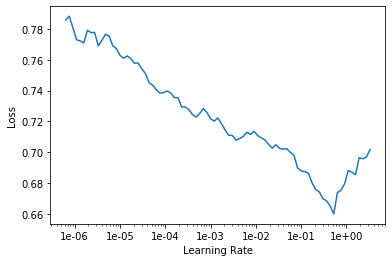

In [37]:
lr_find(learn)
learn.recorder.plot()

In [38]:
lr = 1e-03

In [39]:
learn.fit_one_cycle(30, lr, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="kappa_score_regression", mode="max", patience=7),
                                      SaveBestCallback(learn, monitor='kappa_score_regression',mode='max', 
                                                       name='data_science_bowl_best_model_2')])

epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.617226,0.639501,0.272166,00:05
1,0.583132,0.618483,0.305364,00:05
2,0.548563,0.549400,0.400301,00:05
3,0.495650,0.536233,0.445256,00:05
4,0.477326,0.535974,0.462860,00:05
5,0.459641,0.499671,0.484032,00:05
6,0.453964,0.492348,0.485238,00:05
7,0.441490,0.485753,0.502329,00:05
8,0.439895,0.490491,0.478839,00:05
9,0.436212,0.487859,0.500148,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.2721663389490723.
Better model found at epoch 1 with kappa_score_regression value: 0.3053637440024948.
Better model found at epoch 2 with kappa_score_regression value: 0.40030055684407573.
Better model found at epoch 3 with kappa_score_regression value: 0.4452560512120519.
Better model found at epoch 4 with kappa_score_regression value: 0.4628597554641408.
Better model found at epoch 5 with kappa_score_regression value: 0.4840323064043346.
Better model found at epoch 6 with kappa_score_regression value: 0.48523754122422513.
Better model found at epoch 7 with kappa_score_regression value: 0.502329323507668.
Better model found at epoch 11 with kappa_score_regression value: 0.5103990788901127.
Better model found at epoch 13 with kappa_score_regression value: 0.5205895715349227.
Epoch 21: early stopping
learn best 0.5205895715349227 data_science_bowl_best_model_2


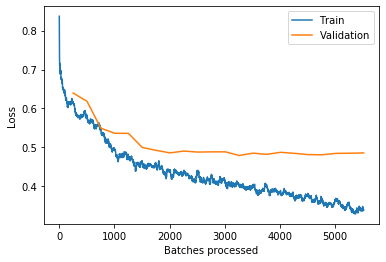

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.fit_one_cycle(20, lr / 10, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="kappa_score_regression", mode="max", patience=7),
                                            SaveBestCallback(learn, monitor='kappa_score_regression',mode='max', name='data_science_bowl_best_model_3')])

epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.378152,0.480876,0.523019,00:05
1,0.371451,0.484246,0.509881,00:05
2,0.386687,0.478718,0.516440,00:05
3,0.361795,0.476250,0.514504,00:05
4,0.372694,0.474050,0.531371,00:05
5,0.368828,0.480271,0.516254,00:05
6,0.361496,0.474832,0.512163,00:05
7,0.356374,0.479511,0.512817,00:05
8,0.364129,0.477611,0.514248,00:05
9,0.365242,0.482842,0.512756,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.5230189048749723.
Better model found at epoch 4 with kappa_score_regression value: 0.5313714592372034.
Epoch 12: early stopping
learn best 0.5313714592372034 data_science_bowl_best_model_3


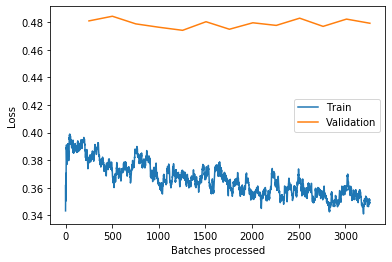

In [42]:
learn.recorder.plot_losses()

## Inference

In [43]:
learn.export(file='/kaggle/model/data_science_bowl_best_model.pkl')

In [45]:
preds_train, y = learn.get_preds(ds_type=DatasetType.Valid)
labels_train = preds_train.flatten()
opt = feature_engineering.OptimizedRounder([0.5, 1.5, 2.0], labels=[0, 1, 2, 3])
opt.fit(labels_train, y)

In [46]:
coefs = opt.coefficients(); coefs
#array([0.9399  , 1.631131, 2.127128])

array([0.564734, 1.568813, 2.286607])

In [47]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)
labels = preds.flatten()

In [48]:
labels = rounder(labels, coefs)

### Data Checks

In [49]:
valid_value_counts = comp_train_df[comp_train_df.index.isin(valid_idx)].groupby('installation_id').last()['accuracy_group'].value_counts(normalize=True)
valid_value_counts

3    0.457279
0    0.282816
1    0.133413
2    0.126492
Name: accuracy_group, dtype: float64

In [50]:
pred_value_counts = pd.Series(labels).value_counts(normalize=True)
pred_value_counts
# 3    0.460
# 2    0.255
# 0    0.165
# 1    0.120

3    0.486
2    0.230
0    0.165
1    0.119
dtype: float64

## Submission

In [51]:
submission_df = pd.DataFrame({'installation_id': comp_test_df['installation_id'], 'accuracy_group': labels})
submission_df

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2
...,...,...
995,fee254cf,3
996,ff57e602,0
997,ffc73fb2,3
998,ffe00ca8,1


In [52]:
def prepare_submission(submission_df):
    sample_submission_df = pd.read_csv(path/'sample_submission.csv')
    sample_submission_df.drop('accuracy_group', inplace = True, axis = 1)
    sample_submission_df = sample_submission_df.merge(submission_df, on = 'installation_id')
    sample_submission_df = sample_submission_df[['installation_id', 'accuracy_group']]
    sample_submission_df.to_csv('submission.csv', index = False)

In [53]:
prepare_submission(submission_df)

In [54]:
!head submission.csv

installation_id,accuracy_group
00abaee7,3
01242218,3
017c5718,3
01a44906,3
01bc6cb6,2
02256298,3
0267757a,2
027e7ce5,3
02a29f99,0


In [55]:
!cat submission.csv | wc -l

1001
